## Multi-Step model using TensorFlow

In [3]:
import numba
import pandas
from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf
import IPython
import IPython.display

2022-12-23 14:32:37.996202: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-23 14:32:41.075141: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib/cuda-11.7/lib64:
2022-12-23 14:32:41.079365: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib/cuda-11.7/lib64:
2022-12-23 14:32:41.079389: W tensorflow/compiler/tf2tensorrt/utils/py_utils.c

In [4]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


2022-12-23 14:32:43.555903: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-12-23 14:32:43.766698: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-12-23 14:32:43.767436: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [5]:
df = pandas.read_csv("1866_2022_3.csv")
date_time = pandas.to_datetime(df.pop('Date'), format='%d/%m/%Y %H:%M:%S')
print(df)

         Valeur  Source
0         3.050       3
1         3.300       3
2         3.550       3
3         3.800       3
4         4.070       3
...         ...     ...
1426559   1.931       3
1426560   1.915       3
1426561   1.918       3
1426562   1.942       3
1426563   1.998       3

[1426564 rows x 2 columns]


In [6]:
values = df.loc[df["Source"] == 3]
#values.pop('Source')
#date_time = pandas.to_datetime(values.pop('Date'), format='%d/%m/%Y %H:%M:%S')
#values["Time"] = [(i)*10 for i in range(len(values))]
#values.drop('Source', axis = 1, inplace = True)
#values['Valeur'] = values['Valeur'].transform(lambda x: int(1000*x))
print(values)

         Valeur  Source
0         3.050       3
1         3.300       3
2         3.550       3
3         3.800       3
4         4.070       3
...         ...     ...
1426559   1.931       3
1426560   1.915       3
1426561   1.918       3
1426562   1.942       3
1426563   1.998       3

[1426564 rows x 2 columns]


KeyError: 'Time'

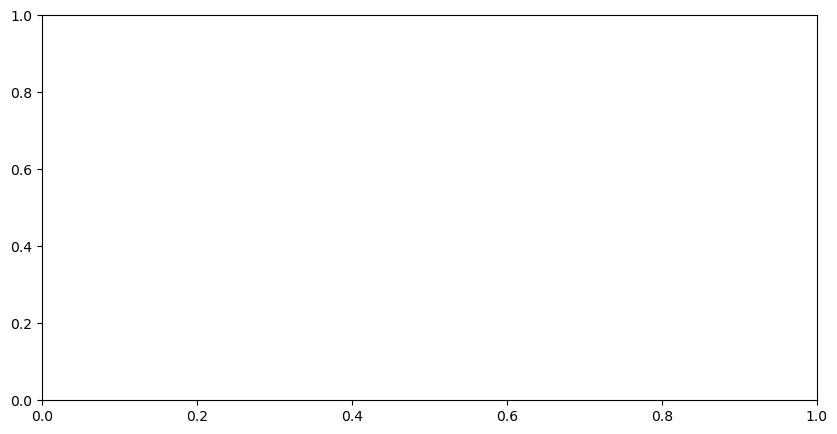

In [7]:
begin = 0
end = 1000
fig, ax = plt.subplots(1, 1, figsize = (10,5))
ax.plot(values['Time'].values[begin:end+1],values['Valeur'].values[begin:end+1])
#ax.set_xlabel(f"Time since  {values['Time'][0]}  (min)")
ax.set_ylabel("Height (m)")
plt.show()

## Fenêtrage des données

In [12]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                                        enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                               enumerate(train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])
    
    def split_window(self, features):
        inputs = features[:, self.input_slice, :]
        print(features.shape)
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:, :, self.column_indices[name]] for name in self.label_columns],
                axis=-1)

        # Slicing doesn't preserve static shape information, so set the shapes
        # manually. This way the `tf.data.Datasets` are easier to inspect.
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])
        print(inputs.shape)
        print(type(inputs))

        return inputs, labels
    
    def plot(self, model=None, plot_col='Valeur', max_subplots=3):
        inputs, labels = self.example
        #print(f"inputs : {inputs[0, :, 2]}")
        #print(f"labels : {labels}")
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        print(self.column_indices)
        #time_index = self.column_indices["Time"]
        max_n = min(max_subplots, len(inputs))
        for n in range(max_n):
            plt.subplot(max_n, 1, n+1)
            plt.ylabel(f'{plot_col}')
            plt.plot([i for i in range(self.input_width)], inputs[n, :, plot_col_index],
                     label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
                label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
                label_col_index = plot_col_index

            if label_col_index is None:
                continue
            #last = inputs[n, :, time_index][-1]

            plt.scatter([i+self.input_width for i in range(self.label_width)], labels[n, :, label_col_index],
                        edgecolors='k', label='Labels', c='#2ca02c', s=64)
            if model is not None:
                predictions = model(inputs)
                plt.scatter([i+self.input_width for i in range(self.label_width)],predictions[n, :, label_col_index],
                          marker='X', edgecolors='k', label='Predictions',
                          c='#ff7f0e', s=64)

            if n == 0:
                plt.legend()

        plt.xlabel('Time')
        
    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        print(data.shape)
        ds = tf.keras.utils.timeseries_dataset_from_array(
          data=data,
          targets=None,
          sequence_length=self.total_window_size,
          sequence_stride=1,
          shuffle=True,
          batch_size=32,)

        ds = ds.map(self.split_window)

        return ds
    
    @property
    def train(self):
        return self.make_dataset(self.train_df)

    @property
    def val(self):
        return self.make_dataset(self.val_df)

    @property
    def test(self):
        return self.make_dataset(self.test_df)

    @property
    def example(self):
        """Get and cache an example batch of `inputs, labels` for plotting."""
        result = getattr(self, '_example', None)
        if result is None:
            # No example batch was found, so get one from the `.train` dataset
            result = next(iter(self.train))
            # And cache it for next time
            self._example = result
        return result

### Données d'entrainements et de validations

In [8]:
n = len(values)
train_df = values[0:int(n*0.7)]
val_df = values[int(n*0.7):int(n*0.9)]
test_df = values[int(n*0.9):]

num_features = df.shape[1]
print(num_features)

print(f"Train : {train_df}")
print(f"Validation : {val_df}")
print(f"Test : {test_df}")

2
Train :         Valeur  Source
0        3.050       3
1        3.300       3
2        3.550       3
3        3.800       3
4        4.070       3
...        ...     ...
998589   2.334       3
998590   2.528       3
998591   2.773       3
998592   3.010       3
998593   3.289       3

[998594 rows x 2 columns]
Validation :          Valeur  Source
998594    3.545       3
998595    3.796       3
998596    4.060       3
998597    4.317       3
998598    4.575       3
...         ...     ...
1283902   4.794       3
1283903   4.604       3
1283904   4.408       3
1283905   4.231       3
1283906   4.034       3

[285313 rows x 2 columns]
Test :          Valeur  Source
1283907   3.858       3
1283908   3.649       3
1283909   3.471       3
1283910   3.270       3
1283911   3.101       3
...         ...     ...
1426559   1.931       3
1426560   1.915       3
1426561   1.918       3
1426562   1.942       3
1426563   1.998       3

[142657 rows x 2 columns]


In [13]:
w2 = WindowGenerator(input_width=100, label_width=1, shift=1, train_df=train_df, val_df=val_df, test_df=test_df)

In [15]:
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           ])
print(train_df[:w2.total_window_size].shape)
example_inputs, example_labels = w2.split_window(example_window)
w2._example = example_inputs, example_labels

(101, 2)
(2, 101, 2)
(2, 100, 2)
<class 'tensorflow.python.framework.ops.EagerTensor'>


{'Valeur': 0, 'Source': 1}


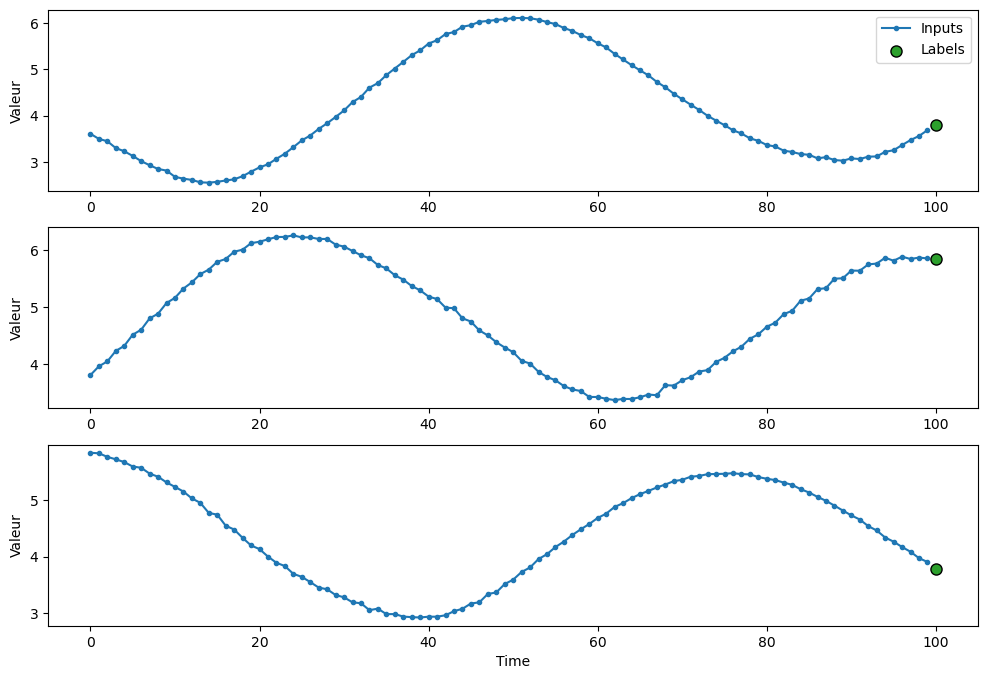

In [11]:
w2.plot()

In [97]:
w2.train.element_spec

(TensorSpec(shape=(None, 100, 2), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

In [98]:
for example_inputs, example_labels in w2.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 100, 2)
Labels shape (batch, time, features): (32, 1, 1)


### Modèle en une seule étape

In [41]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['Valeur'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['Valeur']

### Baseline

In [42]:
class Baseline(tf.keras.Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index

    def call(self, inputs):
        if self.label_index is None:
            return inputs
        result = inputs[:, :, self.label_index]
        return result[:, :, tf.newaxis]

In [46]:
baseline = Baseline(label_index=0)

baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

baseline.fit(single_step_window.train, epochs = 10, steps_per_epoch = 20)

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

Epoch 1/10
20/20 [==============================] - 1s 2ms/step - loss: 0.0182 - mean_absolute_error: 0.1181
Epoch 2/10
20/20 [==============================] - 0s 2ms/step - loss: 0.0189 - mean_absolute_error: 0.1197
Epoch 3/10
20/20 [==============================] - 0s 4ms/step - loss: 0.0190 - mean_absolute_error: 0.1220
Epoch 4/10
20/20 [==============================] - 0s 3ms/step - loss: 0.0190 - mean_absolute_error: 0.1206
Epoch 5/10
20/20 [==============================] - 0s 3ms/step - loss: 0.0187 - mean_absolute_error: 0.1214
Epoch 6/10
20/20 [==============================] - 0s 2ms/step - loss: 0.0185 - mean_absolute_error: 0.1196
Epoch 7/10
20/20 [==============================] - 0s 3ms/step - loss: 0.0190 - mean_absolute_error: 0.1200
Epoch 8/10
20/20 [==============================] - 0s 5ms/step - loss: 0.0201 - mean_absolute_error: 0.1249
Epoch 9/10
20/20 [==============================] - 0s 5ms/step - loss: 0.0189 - mean_absolute_error: 0.1205
Epoch 10/10
2115/21

### Modèle mutli-étapes

2022-12-23 13:26:33.543502: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-23 13:26:33.547873: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-12-23 13:26:33.548250: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-12-23 13:26:33.548523: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_nod

(3, 100, 2)
<class 'tensorflow.python.framework.ops.EagerTensor'>
{'Valeur': 0, 'Source': 1}


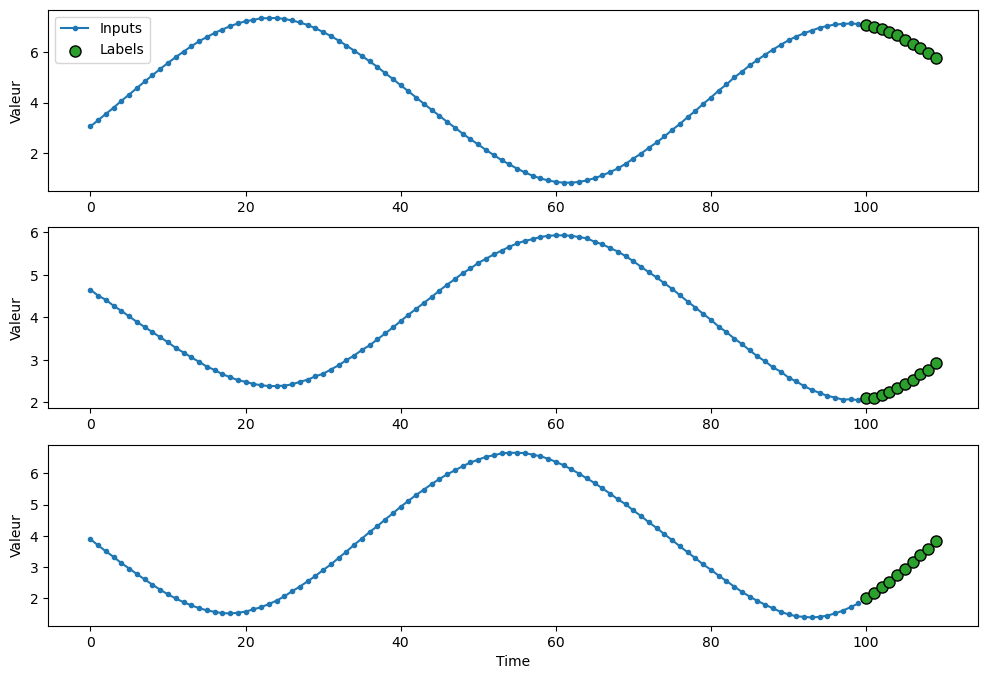

In [7]:
OUT_STEPS = 10
multi_window = WindowGenerator(input_width=100,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS,
                               label_columns = ['Valeur'])

example_window = tf.stack([np.array(train_df[:multi_window.total_window_size]),
                           np.array(train_df[6000:6000+multi_window.total_window_size]),
                           np.array(train_df[50000:50000+multi_window.total_window_size])])

example_inputs, example_labels = multi_window.split_window(example_window)
multi_window._example = example_inputs, example_labels
#print(example_inputs)

multi_window.plot()

### Compile and fit

In [8]:
MAX_EPOCHS = 50
def compile_and_fit(model, window, patience=2):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

    model.compile(loss="mean_squared_error",
                optimizer="adam",
                metrics=["mean_squared_error"])

    history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
    return history

In [9]:
multi_val_performance = {}
multi_performance = {}

### Linéaire

8913/8913 [==============================] - 48s 5ms/step - loss: 0.6286 - mean_absolute_error: 0.6248 - accuracy: 0.0000e+00
{'Valeur': 0, 'Source': 1}


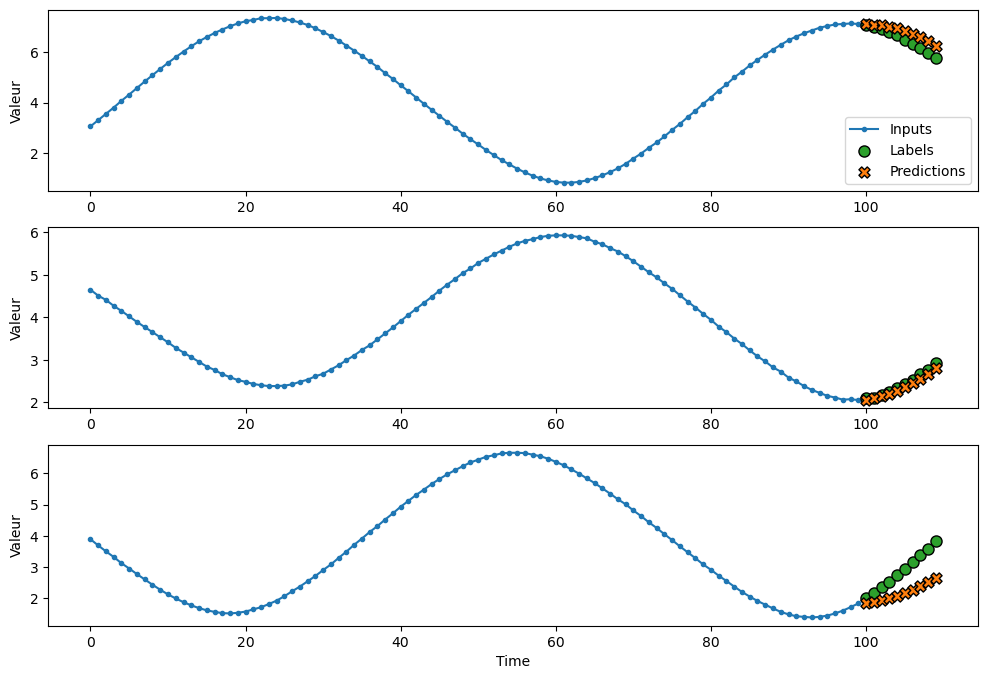

In [10]:
multi_linear_model = tf.keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_linear_model, multi_window)



IPython.display.clear_output()
multi_val_performance['Linear'] = multi_linear_model.evaluate(multi_window.val)
multi_performance['Linear'] = multi_linear_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_linear_model)

### Dense

In [14]:
multi_dense_model = tf.keras.Sequential([
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(512, activation='relu'),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_dense_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Dense'] = multi_dense_model.evaluate(multi_window.val)
multi_performance['Dense'] = multi_dense_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_dense_model)

2111/2111 [==============================] - 11s 5ms/step - loss: 0.6032 - mean_absolute_error: 0.6081


NameError: name 'multi_val_performance' is not defined

### CNN

(None, 100, 2)
<class 'tensorflow.python.framework.ops.Tensor'>
8913/8913 [==============================] - 69s 8ms/step - loss: 0.0082 - mean_squared_error: 0.0082
(None, 100, 2)
<class 'tensorflow.python.framework.ops.Tensor'>
{'Valeur': 0, 'Source': 1}


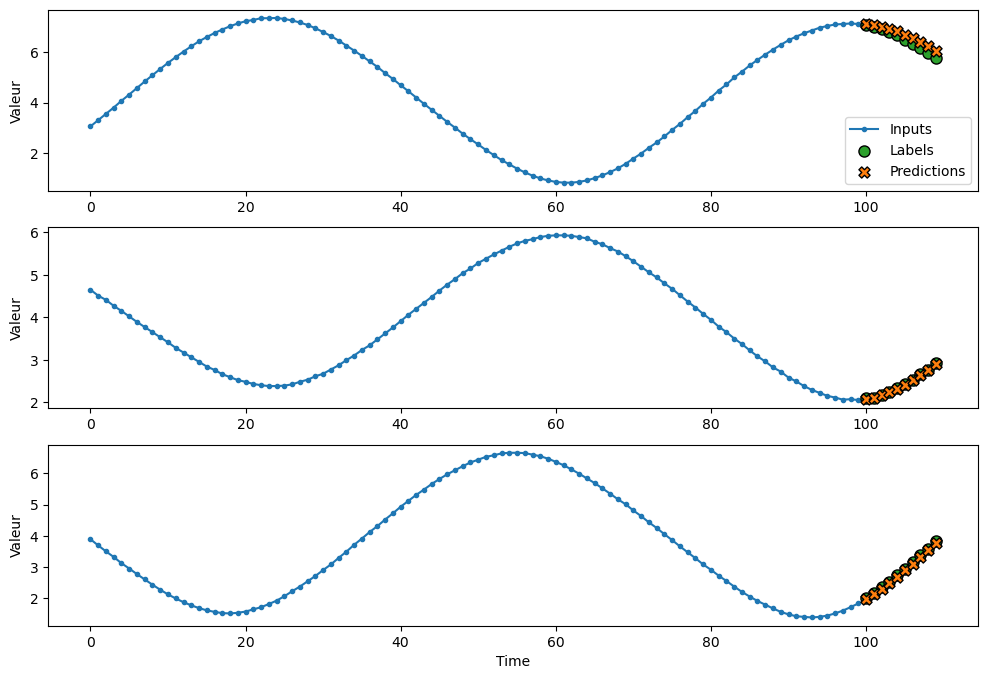

In [11]:
CONV_WIDTH = 3
multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -3:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(128, activation='relu', kernel_size=(3)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([10, 2])
])

history = compile_and_fit(multi_conv_model, multi_window)

IPython.display.clear_output()

multi_val_performance['Conv'] = multi_conv_model.evaluate(multi_window.val)
multi_performance['Conv'] = multi_conv_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_conv_model)

In [12]:
multi_conv_model.save("models/MultiCNN")

INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 2, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7facccfa6320>, 140380149621232), {}).
INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(128,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7faccc6307c0>, 140380149621312), {}).
INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(None, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7faccc6324a0>, 140380149623232), {}).
INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7faccc604910>, 140380149622592), {}).
INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 2, 128),

INFO:tensorflow:Assets written to: models/MultiCNN/assets


INFO:tensorflow:Assets written to: models/MultiCNN/assets


### RNN

In [ ]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS*num_features,kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)

IPython.display.clear_output()

multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_lstm_model)

Epoch 1/50


2022-12-15 15:16:57.284547: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8700


31203/31203 [==============================] - 504s 16ms/step - loss: 0.0676 - mean_absolute_error: 0.0736 - accuracy: 0.0000e+00 - val_loss: 0.0039 - val_mean_absolute_error: 0.0380 - val_accuracy: 0.0000e+00
Epoch 2/50
31203/31203 [==============================] - 488s 16ms/step - loss: 0.0040 - mean_absolute_error: 0.0343 - accuracy: 0.0000e+00 - val_loss: 0.0032 - val_mean_absolute_error: 0.0304 - val_accuracy: 0.0000e+00
Epoch 3/50
31203/31203 [==============================] - 450s 14ms/step - loss: 0.0036 - mean_absolute_error: 0.0321 - accuracy: 0.0000e+00 - val_loss: 0.0031 - val_mean_absolute_error: 0.0312 - val_accuracy: 0.0000e+00
Epoch 4/50
31203/31203 [==============================] - 468s 15ms/step - loss: 0.0033 - mean_absolute_error: 0.0307 - accuracy: 0.0000e+00 - val_loss: 0.0026 - val_mean_absolute_error: 0.0262 - val_accuracy: 0.0000e+00
Epoch 5/50
31203/31203 [==============================] - 511s 16ms/step - loss: 0.0032 - mean_absolute_error: 0.0296 - accurac

In [ ]:
multi_lstm_model.save('models/multi_lstm_model.h5')

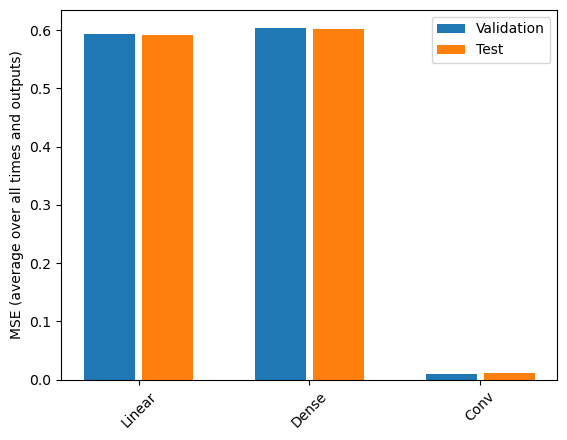

In [44]:
x = np.arange(len(multi_performance))
width = 0.3

metric_name = 'mean_squared_error'
metric_index = multi_dense_model.metrics_names.index('mean_squared_error')
val_mae = [v[metric_index] for v in multi_val_performance.values()]
test_mae = [v[metric_index] for v in multi_performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
plt.ylabel(f'MSE (average over all times and outputs)')
_ = plt.legend()

### RNN Auto-régréssif

In [16]:
class FeedBack(tf.keras.Model):
    def __init__(self, units, out_steps):
        super().__init__()
        self.out_steps = out_steps
        self.units = units
        self.lstm_cell = tf.keras.layers.LSTMCell(units)
        # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
        self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
        self.dense = tf.keras.layers.Dense(num_features)
        
    def warmup(self, inputs):
        # inputs.shape => (batch, time, features)
        # x.shape => (batch, lstm_units)
        x, *state = self.lstm_rnn(inputs)

        # predictions.shape => (batch, features)
        prediction = self.dense(x)
        return prediction, state
    
    def call(self, inputs, training=None):
        # Use a TensorArray to capture dynamically unrolled outputs.
        predictions = []
        # Initialize the LSTM state.
        prediction, state = self.warmup(inputs)

        # Insert the first prediction.
        predictions.append(prediction)

        # Run the rest of the prediction steps.
        for n in range(1, self.out_steps):
            # Use the last prediction as input.
            x = prediction
            # Execute one lstm step.
            x, state = self.lstm_cell(x, states=state,
                                      training=training)
            # Convert the lstm output to a prediction.
            prediction = self.dense(x)
            # Add the prediction to the output.
            predictions.append(prediction)

        # predictions.shape => (time, batch, features)
        predictions = tf.stack(predictions)
        # predictions.shape => (batch, time, features)
        predictions = tf.transpose(predictions, [1, 0, 2])
        return predictions

In [17]:
feedback_model = FeedBack(units=32, out_steps=OUT_STEPS)

In [18]:
prediction, state = feedback_model.warmup(multi_window.example[0])
prediction.shape

TensorShape([3, 2])

In [21]:
history = compile_and_fit(feedback_model, multi_window)

IPython.display.clear_output()

multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val)
multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(feedback_model)

2111/2111 [==============================] - 23s 11ms/step - loss: 0.0079 - mean_absolute_error: 0.0503


NameError: name 'multi_val_performance' is not defined

### RNN Perso

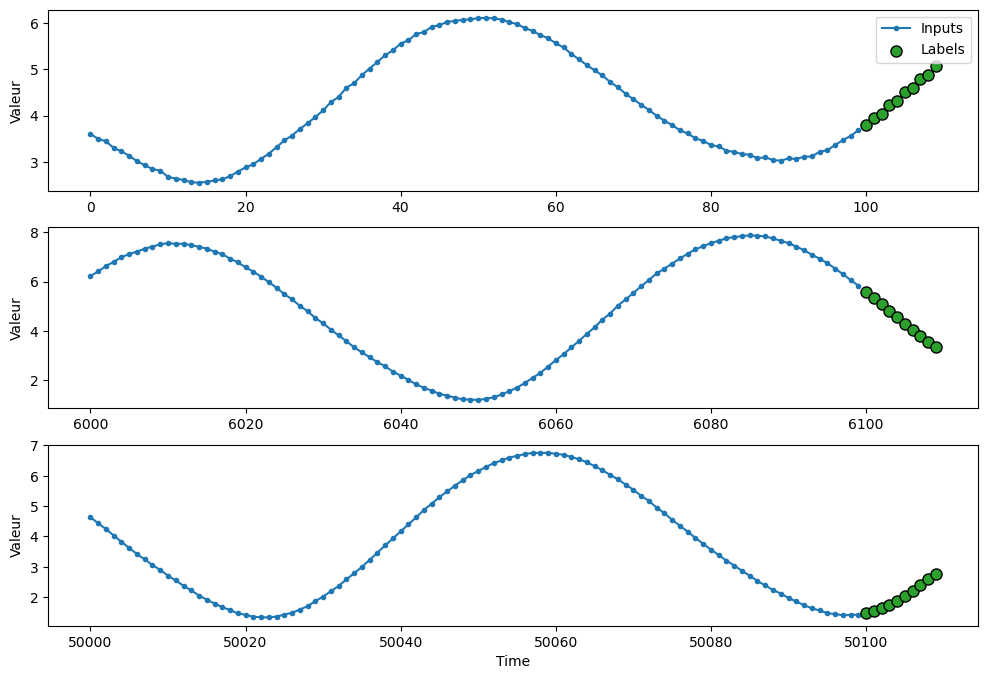

In [24]:
OUT_STEPS = 10
multi_window = WindowGenerator(input_width=100,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

example_window = tf.stack([np.array(train_df[:multi_window.total_window_size]),
                           np.array(train_df[6000:6000+multi_window.total_window_size]),
                           np.array(train_df[50000:50000+multi_window.total_window_size])])

example_inputs, example_labels = multi_window.split_window(example_window)
multi_window._example = example_inputs, example_labels

multi_window.plot()

In [227]:
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(OUT_STEPS*num_features),
    tf.keras.layers.Reshape([OUT_STEPS, num_features])])
model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
history = model.fit(
    multi_window.train,
    epochs=5,
    validation_data=multi_window.val,
    validation_steps=3
)

Epoch 1/5
   2/7396 [..............................] - ETA: 8:17 - loss: 19.9042   

model.evaluate(multi_window.test)
multi_window.plot(model)